In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import osmnx as ox

### 1. Load isochrone polygon files as base

In [2]:
%%time
# takes 15 min to load
# import flow_rail_isochrone data
rail_isochrone = gpd.read_file(os.path.join('data','cleaned','rail_isochrone.geojson'))
# Read the flow_bus_isochrone dataset from file
bus_isochrone = gpd.read_file(os.path.join('data','cleaned','bus_isochrone.geojson'))

In [5]:
rail_isochrone['pt_type'] = 'rail'
bus_isochrone['pt_type'] = 'bus'
# rename columns
rail_isochrone.rename(columns={'nlc':'id_code'}, inplace=True) # rename nlc column to id_code
bus_isochrone.rename(columns={'stop_id':'id_code'}, inplace=True) # rename nlc column to id_code

### 2. TARGET VARIABLE

In [92]:
# Merge with BUSTO data
flow_bus = gpd.read_file(os.path.join('data','cleaned','flow_bus_byStop_.geojson'))
flow_bus.STOPCODE = flow_bus.STOPCODE.astype(str)
# # merge with pt_isochrone pt_type bus
bus_isochrone_merge = bus_isochrone[['id_code','pt_type','geometry']].merge(flow_bus[['STOPCODE',
                                            'Early',
                                            # 'AM Peak',
                                            # 'Midday',
                                            # 'PM Peak',
                                            # 'Evening',
                                            # 'Late',
                                            'Total']],left_on='id_code',right_on='STOPCODE',how='left').drop('STOPCODE',axis=1)

# Sample dataset does not have other timebands for now -> insert dummy columns
bus_isochrone_merge['AM Peak'] = 0
bus_isochrone_merge['Midday'] = 0
bus_isochrone_merge['PM Peak'] = 0
bus_isochrone_merge['Evening'] = 0
bus_isochrone_merge['Late'] = 0

bus_isochrone_merge.fillna(0,inplace=True)

bus_isochrone_merge.tail()

,id_code,pt_type,geometry,Early,Total,AM Peak,Midday,PM Peak,Evening,Late
19620,W46,bus,"POLYGON ((525359.566 168443.041, 525357.420 16...",0.0,0.0,0,0,0,0,0
19621,W48,bus,"POLYGON ((525492.930 168444.287, 525491.141 16...",0.0,0.0,0,0,0,0,0
19622,W5,bus,"POLYGON ((538223.666 162836.168, 538223.475 16...",0.0,0.0,0,0,0,0,0
19623,W6,bus,"POLYGON ((538060.529 162751.767, 538058.551 16...",0.0,0.0,0,0,0,0,0
19624,W7,bus,"POLYGON ((535147.602 161941.817, 535145.152 16...",0.0,0.0,0,0,0,0,0


In [94]:
flow_rail = gpd.read_file(os.path.join('data','cleaned','flow_rail.geojson'))
flow_rail.nlc = flow_rail.nlc.astype(str)
rail_isochrone.id_code = rail_isochrone.id_code.astype(str)
# merge with pt_isochrone pt_type bus
rail_isochrone_merge = rail_isochrone[['id_code','pt_type','geometry']].merge(flow_rail[['nlc',
                                            'Early',
                                            'AM Peak',
                                            'Midday',
                                            'PM Peak',
                                            'Evening',
                                            'Late',
                                            'Total']],left_on='id_code',right_on='nlc',how='left').drop('nlc',axis=1)

rail_isochrone_merge.tail()

,id_code,pt_type,geometry,Early,AM Peak,Midday,PM Peak,Evening,Late,Total
395,769,rail,"POLYGON ((540539.580 191372.388, 540495.948 19...",59,330,1711,1457,1015,730,5301
396,7467,rail,"POLYGON ((541670.382 184927.695, 541669.734 18...",14,130,395,272,181,98,1090
397,771,rail,"POLYGON ((525027.511 191507.238, 525025.058 19...",21,304,1492,1525,1137,917,5396
398,573,rail,"POLYGON ((543353.410 178612.042, 543353.136 17...",479,1644,4295,2706,1830,1366,12320
399,6562,rail,"POLYGON ((543584.968 179028.793, 543585.547 17...",114,906,4559,3699,2888,1847,14013


In [102]:
#concatenate into one dataset

col = ['id_code','pt_type','geometry','Early', 'AM Peak','Midday','PM Peak','Evening','Late','Total']
pt_isochrone = pd.concat([
                            rail_isochrone_merge[col],
                            bus_isochrone_merge[col]
                            ])
pt_isochrone.reset_index(inplace=True, drop=True)

pt_isochrone.id_code = pt_isochrone.id_code.astype(str)
pt_isochrone['Early'] = pt_isochrone['Early'].astype(int) # unify to integer
pt_isochrone['Total'] = pt_isochrone['Total'].astype(int) # unify to integer

pt_isochrone.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20025 entries, 0 to 20024
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id_code   20025 non-null  object  
 1   pt_type   20025 non-null  object  
 2   geometry  20025 non-null  geometry
 3   Early     20025 non-null  int32   
 4   AM Peak   20025 non-null  int64   
 5   Midday    20025 non-null  int64   
 6   PM Peak   20025 non-null  int64   
 7   Evening   20025 non-null  int64   
 8   Late      20025 non-null  int64   
 9   Total     20025 non-null  int32   
dtypes: geometry(1), int32(2), int64(5), object(2)
memory usage: 1.4+ MB


#### Plot 

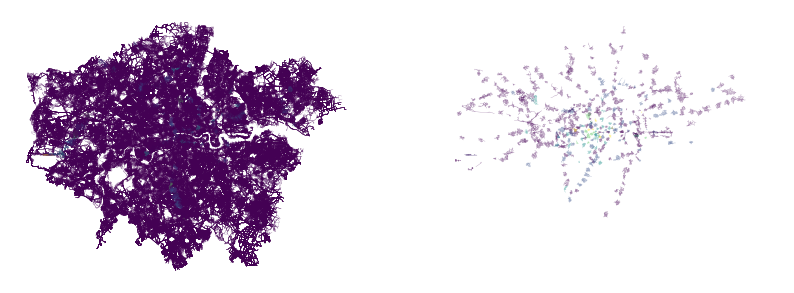

In [113]:
# plot them
fig, ax = plt.subplots(1,2,figsize=(10,20),sharex=True,sharey=True)
pt_isochrone[pt_isochrone.pt_type=='bus'].plot(ax=ax[0], column='Total', alpha=0.5, cmap='viridis',scheme='NaturalBreaks',k=5)
pt_isochrone[pt_isochrone.pt_type=='rail'].plot(ax=ax[1], column='Total', alpha=0.5, cmap='viridis',scheme='NaturalBreaks',k=5)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

### 3. FEATURES
#### 3.1 Aggregate intersecting Population and POI density

In [114]:
# import poi_pop_h3 file
poi_pop_h3 = gpd.read_file(os.path.join('data','cleaned','poi_pop_h3_r10.geojson'))
poi_pop_h3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 116586 entries, 0 to 116585
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   h3                 116586 non-null  object  
 1   population         116586 non-null  int64   
 2   banking            116586 non-null  float64 
 3   hotels             116586 non-null  float64 
 4   leisure_active     116586 non-null  float64 
 5   leisure_nightlife  116586 non-null  float64 
 6   leisure_outdoor    116586 non-null  float64 
 7   medical            116586 non-null  float64 
 8   nature             116586 non-null  float64 
 9   public_facilities  116586 non-null  float64 
 10  religious          116586 non-null  float64 
 11  restaurants        116586 non-null  float64 
 12  shopping           116586 non-null  float64 
 13  tourism            116586 non-null  float64 
 14  transport          116586 non-null  float64 
 15  geometry           116586 

In [115]:
%%time
# takes 1hr
# for each isochrone, calculate the values from poi_pop_h3 intersecting it 
df_ml = pt_isochrone.copy()

for i, row in df_ml.iterrows():
    intersect = poi_pop_h3[poi_pop_h3.geometry.intersects(row.geometry)] # find intersected polygons
    for col in intersect.columns[1:15]: # there are 14 columns to aggregate
        value = intersect[col].sum() # agg by sum
        df_ml.at[i, col] = round(value) # assign sum to the row

df_ml.head()

#### 3.2 Calculate POI diversity - Shannon entropy within each isochrone

In [ ]:
# calculate the entropy of all rows
from scipy.stats import entropy
def calculate_entropy(row):
    # get the values of the row
    c = row.values[5:16].astype(int)
    # remove zeros
    c = c[c != 0]
    c = c / c.sum()
    # calculate the entropy
    ent = entropy(c)
    return ent

df_ml['shannon_ent'] = df_ml.apply(calculate_entropy, axis=1)

(500950.8766223728, 564298.121720478, 153770.65374416485, 202941.95919412468)

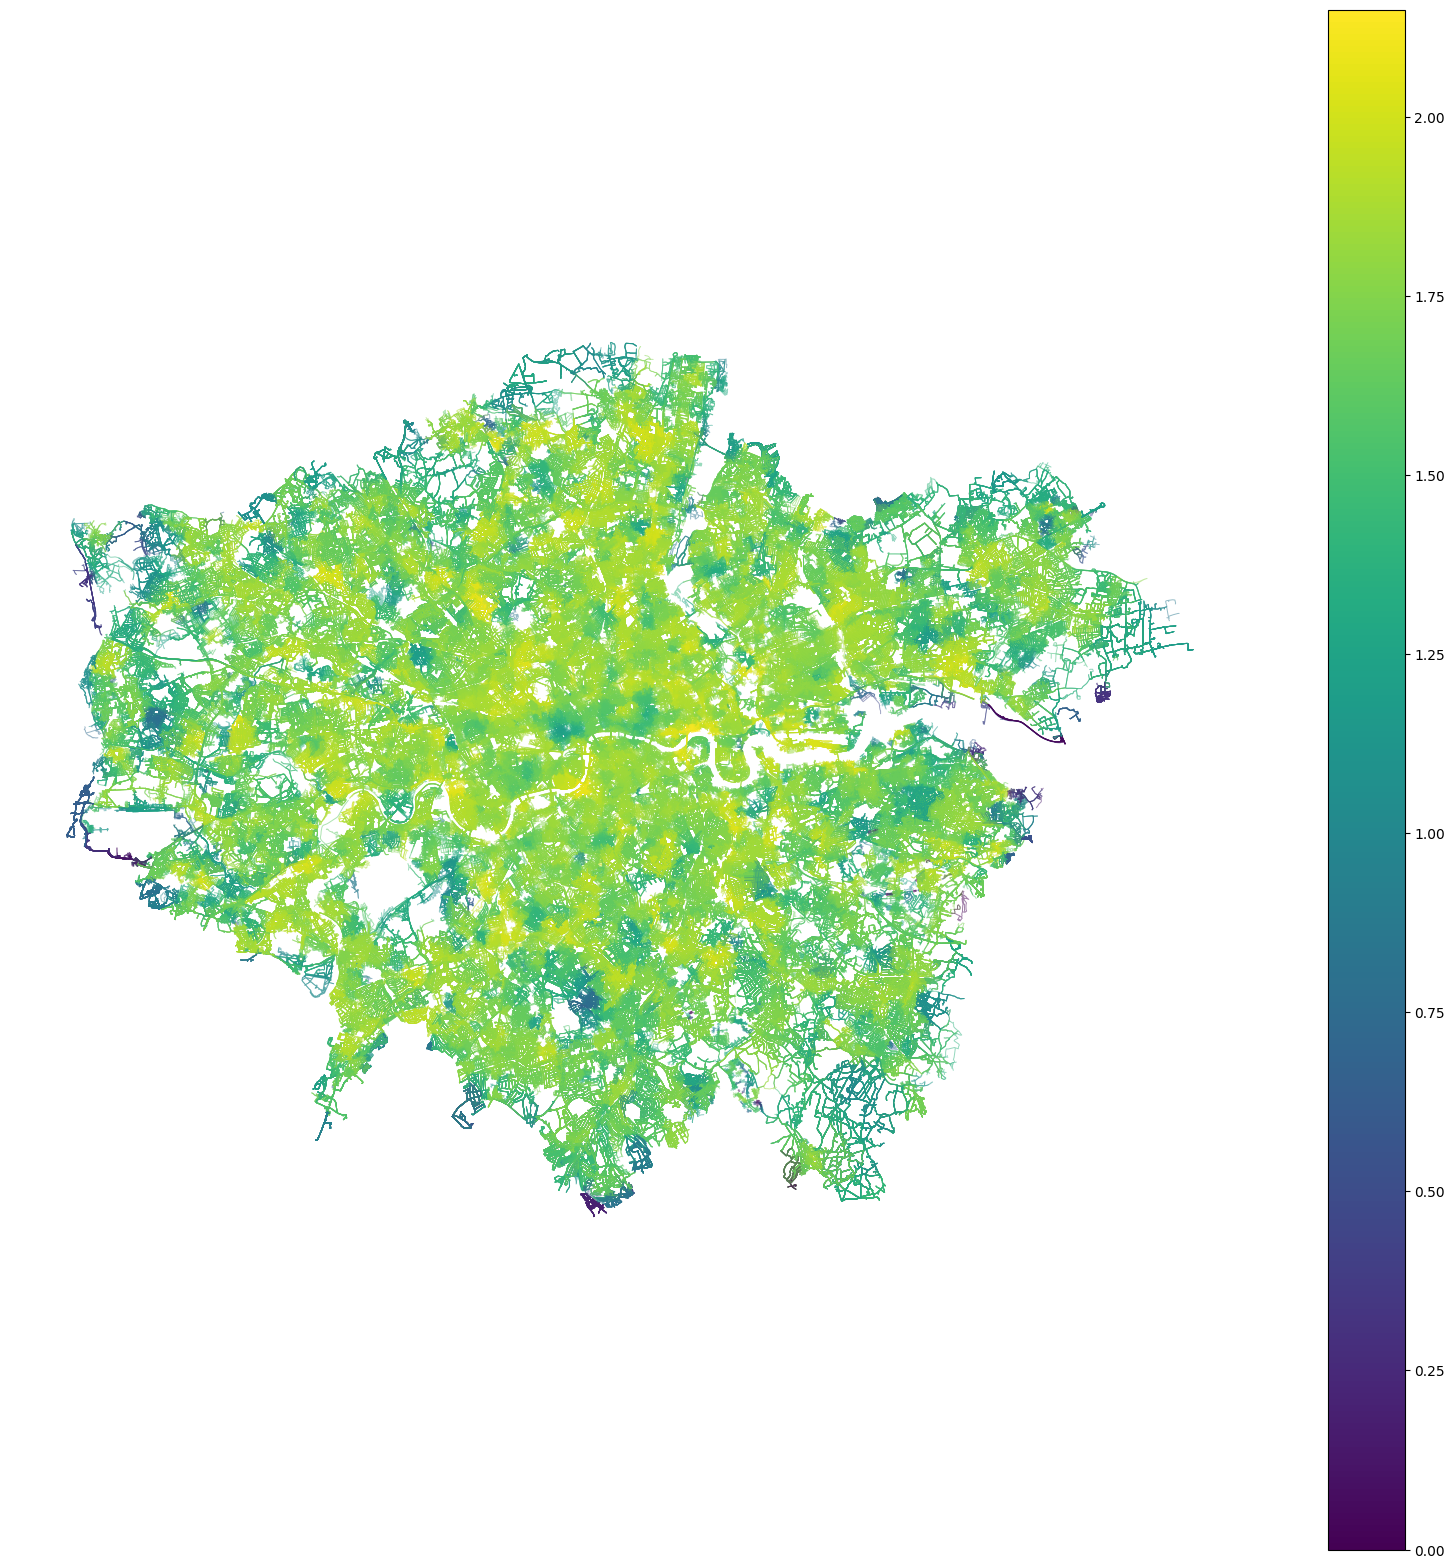

In [ ]:
# plot it
fig, ax = plt.subplots(figsize=(20,20))
df_ml.plot(column='shannon_ent', ax=ax,legend=True, alpha=0.5, cmap='viridis')
ax.axis('off')

(500648.73379679717, 564876.9613396714, 153596.6380031262, 203188.05353467062)

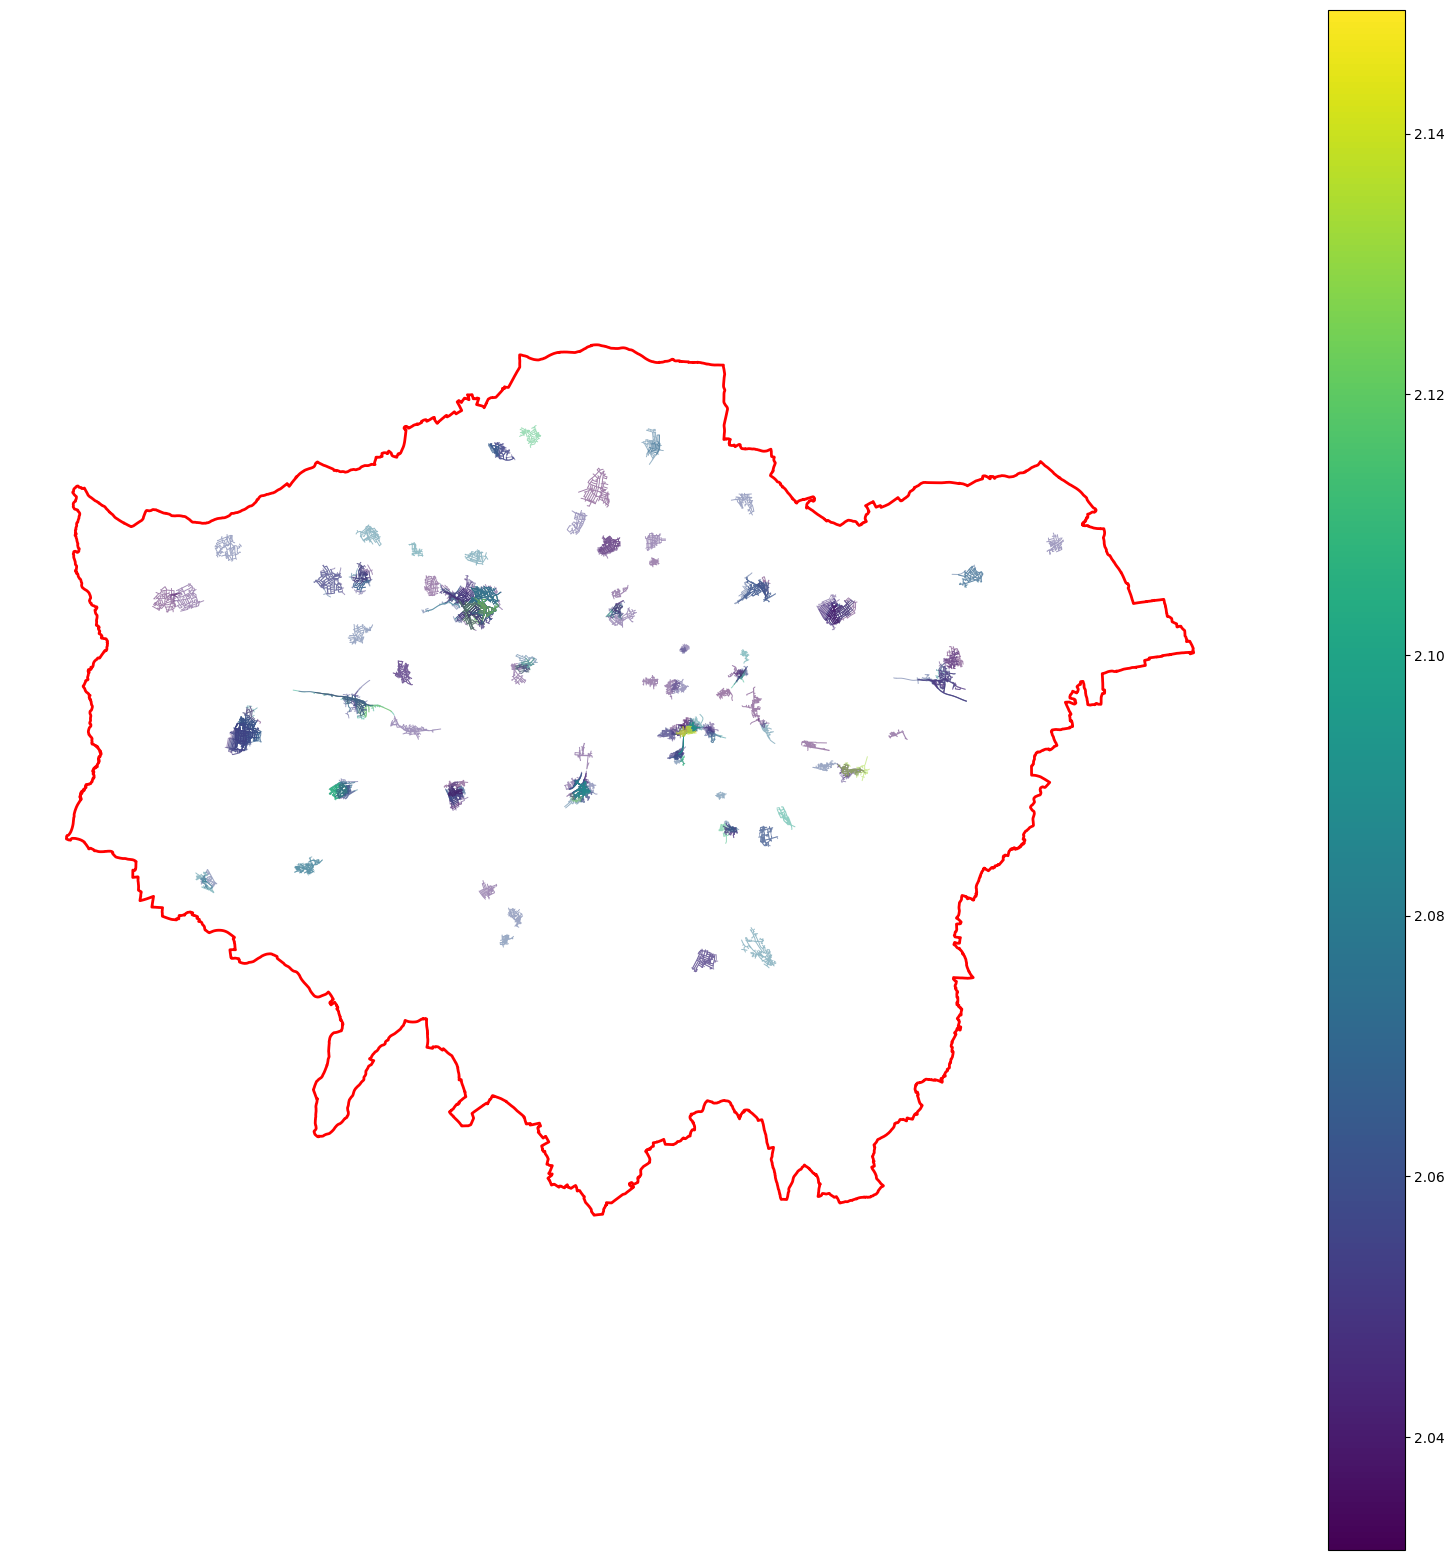

In [ ]:
# plot it where entropy is greater than top quartile
fig, ax = plt.subplots(figsize=(20,20))
df_ml[df_ml.shannon_ent > df_ml.shannon_ent.quantile(0.99)].plot(
            column='shannon_ent', 
            ax=ax,
            legend=True,
            alpha=0.5,
            cmap='viridis'
            )
# london boundary from osm
london = ox.geocode_to_gdf('Greater London, UK')
london.to_crs(epsg=27700, inplace=True)
london.boundary.plot(ax=ax, color='red', linewidth=2)
ax.axis('off')

In [ ]:
# draw folium map
import folium

# create a folium map of london
m = folium.Map(location=[51.5074, -0.1278], zoom_start=10, tiles='cartodbpositron')

df_plot = df_ml[df_ml.shannon_ent > df_ml.shannon_ent.quantile(0.8)].to_crs(epsg=4326)
# add the shannon entropy layer
folium.Choropleth(
    geo_data=df_plot,
    name='choropleth',
    data=df_plot,
    columns=['id_code', 'shannon_ent'],
    key_on='feature.properties.id_code',
    fill_color='YlGn',
    fill_opacity=0.6,
    line_opacity=0,
    legend_name='POI Diversity'
).add_to(m)

m

Aggregate centrality measures (max_rail, max_bus) for each iso

Export to file

In [ ]:
df_ml.to_file(os.path.join('data','cleaned','df_ml.geojson'), driver='GeoJSON')